## Importing Libraries

In [1]:
from fastai.text import *
from fastai.callbacks import *
from fastai.utils.mem import *

## Downloading Data and Setting Up Paths

In [2]:
path = untar_data(URLs.IMDB)
print(path)
path.ls()

C:\Users\RAJDEEP\.fastai\data\imdb


[WindowsPath('C:/Users/RAJDEEP/.fastai/data/imdb/imdb.vocab'),
 WindowsPath('C:/Users/RAJDEEP/.fastai/data/imdb/models'),
 WindowsPath('C:/Users/RAJDEEP/.fastai/data/imdb/README'),
 WindowsPath('C:/Users/RAJDEEP/.fastai/data/imdb/test'),
 WindowsPath('C:/Users/RAJDEEP/.fastai/data/imdb/tmp_clas'),
 WindowsPath('C:/Users/RAJDEEP/.fastai/data/imdb/tmp_lm'),
 WindowsPath('C:/Users/RAJDEEP/.fastai/data/imdb/train'),
 WindowsPath('C:/Users/RAJDEEP/.fastai/data/imdb/unsup')]

## Training the Lanuage Model

**Creating the DataBunch**

In [3]:
batch_size = 64

In [4]:
data_lm = (TextList.from_folder(path)
                   .filter_by_folder(include = ['train', 'test', 'unsup'])
                   .split_by_rand_pct(valid_pct = 0.15)
                   .label_for_lm()
                   .databunch(bs = batch_size))

data_lm

TextLMDataBunch;

Train: LabelList (85000 items)
x: LMTextList
xxbos xxmaj once again xxmaj mr. xxmaj costner has dragged out a movie for far longer than necessary . xxmaj aside from the terrific sea rescue sequences , of which there are very few i just did not care about any of the characters . xxmaj most of us have ghosts in the closet , and xxmaj costner 's character are realized early on , and then forgotten until much later , by which time i did not care . xxmaj the character we should really care about is a very cocky , overconfident xxmaj ashton xxmaj kutcher . xxmaj the problem is he comes off as kid who thinks he 's better than anyone else around him and shows no signs of a cluttered closet . xxmaj his only obstacle appears to be winning over xxmaj costner . xxmaj finally when we are well past the half way point of this stinker , xxmaj costner tells us all about xxmaj kutcher 's ghosts . xxmaj we are told why xxmaj kutcher is driven to be the best with no prior inkling or fore

In [5]:
data_lm.save("data_language_model.pkl")

**Loading the DataBunch**

In [4]:
data_lm = load_data(path, "data_language_model.pkl",  bs = batch_size)

In [5]:
data_lm.show_batch(4)

idx,text
0,"later , by which time i did not care . xxmaj the character we should really care about is a very cocky , overconfident xxmaj ashton xxmaj kutcher . xxmaj the problem is he comes off as kid who thinks he 's better than anyone else around him and shows no signs of a cluttered closet . xxmaj his only obstacle appears to be winning over xxmaj costner . xxmaj"
1,"would n't recommend it to anyone . xxmaj the xxmaj adventures of xxmaj sebastian xxmaj cole is n't a bad or boring film , it 's just not a very good or engaging one either . xxmaj it 's very uneven and the script could 've used quite a bit of work . i guess the point of the film is to be a loose sort of look at the"
2,"any of them stay on as xxmaj ada and her father were unusually benevolent , and ( as shown in one scene ) it was a very dangerous time for xxmaj negroes ( as they 're politely called here ) . xxmaj why did n't the neighbors teach her how to milk a cow or grow a crop ? xxmaj heck , why did n't she just sell the farm"
3,"from man to boy - child . \n \n xxunk 's love interest in book ( xxmaj nora ) , is now his xxunk all her depth and character growth is completely gone . \n \n xxunk xxmaj johnson , black man , is now white xxmaj mr. xxmaj ironside . xxmaj this matters as the character 's strength was built on his heritage in the book ."


In [6]:
print("Vocabulary Length:", len(data_lm.vocab.itos))
print(data_lm.vocab.itos[:20])

Vocabulary Length: 60000
['xxunk', 'xxpad', 'xxbos', 'xxeos', 'xxfld', 'xxmaj', 'xxup', 'xxrep', 'xxwrep', 'the', '.', ',', 'and', 'a', 'of', 'to', 'is', 'it', 'in', 'i']


**Creating the Learner**

In [9]:
learn_lm = language_model_learner(data_lm, AWD_LSTM, drop_mult = 0.3).to_fp16()

**Fitting the Learner**

epoch,train_loss,valid_loss,accuracy,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


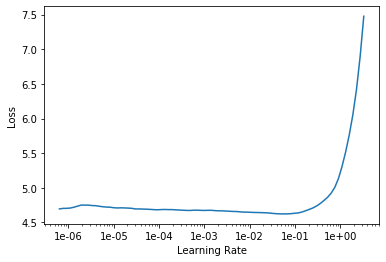

In [10]:
learn_lm.lr_find()
learn_lm.recorder.plot()

In [11]:
learning_rate = 1e-2
learn_lm.fit_one_cycle(7, max_lr = learning_rate, moms = (0.8,0.7))

epoch,train_loss,valid_loss,accuracy,time
0,4.137644,4.034529,0.292002,13:56
1,4.235580,4.120438,0.284412,13:52
2,4.171474,4.103796,0.286223,13:27
3,4.160728,4.058620,0.289386,13:36
4,4.069509,3.996249,0.295239,13:38
5,3.997544,3.954338,0.299348,13:32
6,3.931939,3.945895,0.300497,13:43


In [12]:
learn_lm.save("lm_freezed")

**Clearing the GPU Memory**

In [13]:
gpu_mem_get_free_no_cache()

5974

**Finetuning the Learner**

In [14]:
learn_lm.load("lm_freezed");

epoch,train_loss,valid_loss,accuracy,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


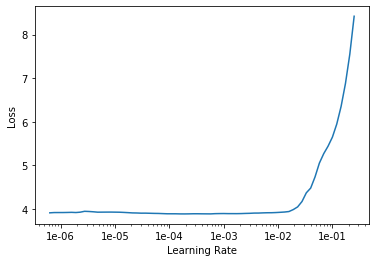

In [15]:
learn_lm.unfreeze()
learn_lm.lr_find()
learn_lm.recorder.plot()

In [16]:
learning_rate = 1e-3
learn_lm.fit_one_cycle(10, max_lr = learning_rate, moms = (0.8,0.7))

epoch,train_loss,valid_loss,accuracy,time
0,3.758382,3.778092,0.318236,15:24
1,3.743726,3.737737,0.324937,15:37
2,3.695990,3.709277,0.329300,15:48
3,3.672724,3.679226,0.333274,15:43
4,3.581224,3.656943,0.336174,15:40
5,3.511540,3.638901,0.338549,15:48
6,3.467445,3.629427,0.340152,15:40
7,3.390421,3.625178,0.341253,15:45
8,3.336178,3.627153,0.341281,15:56
9,3.288524,3.631823,0.340963,15:45


In [17]:
learn_lm.save("lm_unfreezed")

**Saving the Encoder**

In [18]:
learn_lm.save_encoder("lm_encoder")

**Testing the Language Model**

In [19]:
learn_lm.load("lm_unfreezed");

In [20]:
text = "This is a fine "
words_per_sentence = 50
n_sentences = 4

In [21]:
for _ in range(n_sentences):
    print(learn_lm.predict(text, words_per_sentence, temperature = 0.4))
    print()

This is a fine  film . It 's a great story , and it 's a very good story . The characters are real and the story is very real . The film is about a man who went to jail and was forced to live with his mother , who

This is a fine  British film , with a good cast , and a great story . The story is about a young British man ( Kevin Kline ) who is forced to live in England after his father 's death . He is told that he

This is a fine  movie . It is a very good movie . It is about a woman who is trying to make a life for herself . She is a woman who has the ability to be a person . She is a woman that is not willing to

This is a fine  movie . The story is very interesting and the acting is good . The story is very interesting and the characters are well developed . The movie is very well made and the acting is very good . The movie is very well filmed and the



## Exporting the trained Language Model

In [31]:
learn_lm.export('final_trained_language_model.pkl', destroy = True)

this Learner object self-destroyed - it still exists, but no longer usable


## Training the Classifier

**Clearing the GPU Memory**

In [32]:
gpu_mem_get_free_no_cache()

6576

**Creating the Databunch**

In [7]:
batch_size = 32
n_workers = 6

In [25]:
#Run this in case you are experiencing BrokenProcessPool error while creating the DataBunch for the classifier
defaults.cpus = 1

In [26]:
data_class = (TextList.from_folder(path, vocab = data_lm.vocab)
                      .split_by_folder(train = 'train', valid = 'test')
                      .label_from_folder()
                      .databunch(bs = batch_size, num_workers = n_workers))

data_class

TextClasDataBunch;

Train: LabelList (25000 items)
x: TextList
xxbos xxmaj story of a man who has unnatural feelings for a pig . xxmaj starts out with a opening scene that is a terrific example of absurd comedy . a formal orchestra audience is turned into an insane , violent mob by the crazy xxunk of it 's singers . xxmaj unfortunately it stays absurd the xxup whole time with no general narrative eventually making it just too off putting . xxmaj even those from the era should be turned off . xxmaj the cryptic dialogue would make xxmaj shakespeare seem easy to a third grader . xxmaj on a technical level it 's better than you might think with some good cinematography by future great xxmaj vilmos xxmaj zsigmond . xxmaj future stars xxmaj sally xxmaj kirkland and xxmaj frederic xxmaj forrest can be seen briefly .,xxbos xxmaj airport ' 77 starts as a brand new luxury 747 plane is loaded up with valuable paintings & such belonging to rich businessman xxmaj philip xxmaj stevens ( xxmaj james 

In [27]:
data_class.save("data_classifier.pkl")

**Loading the DataBunch**

In [8]:
data_class = load_data(path, "data_classifier.pkl", bs = batch_size, num_workers = n_workers)

In [9]:
data_class.show_batch()

text,target
xxbos xxmaj match 1 : xxmaj tag xxmaj team xxmaj table xxmaj match xxmaj bubba xxmaj ray and xxmaj spike xxmaj dudley vs xxmaj eddie xxmaj guerrero and xxmaj chris xxmaj benoit xxmaj bubba xxmaj ray and xxmaj spike xxmaj dudley started things off with a xxmaj tag xxmaj team xxmaj table xxmaj match against xxmaj eddie xxmaj guerrero and xxmaj chris xxmaj benoit . xxmaj according to the rules,pos
"xxbos xxmaj pier xxmaj paolo xxmaj pasolini , or xxmaj pee - pee - pee as i prefer to call him ( due to his love of showing male genitals ) , is perhaps xxup the most overrated xxmaj european xxmaj marxist director - and they are thick on the ground . xxmaj how anyone can see "" art "" in this messy , cheap sex - romp concoction is",neg
"xxbos i figured that it 's about time i let this one out . xxmaj pokémon fans are suffering in xxmaj america these days . xxmaj why ? xxmaj because we rely on xxmaj kids xxup wb and 4kids xxmaj entertainment to provide us with our beloved series and movies . xxmaj as far as the series goes , they do a pretty good job in bringing the fun and",neg
"xxbos xxmaj sometimes a film comes along that is unique . xxmaj the xxmaj nostril xxmaj picker is one such film , xxmaj the xxmaj nostril xxmaj picker is like no other film i have ever seen , unfortunately for xxmaj the xxmaj nostril xxmaj picker & myself it 's unique for different reasons than what the filmmakers had originally intended . xxmaj read on & all shall hopefully become",neg
"xxbos xxmaj many neglect that this is n't just a classic due to the fact that it 's the first xxup 3d game , or even the first shoot-'em - up . xxmaj it 's also one of the first stealth games , one of the xxunk definitely the first ) truly claustrophobic games , and just a pretty well - rounded gaming experience in general . xxmaj with graphics",pos


In [10]:
print("Classes: ", data_class.classes)

Classes:  ['neg', 'pos']


**Creating the Learner**

In [11]:
learn_class = text_classifier_learner(data_class, AWD_LSTM, drop_mult = 0.5).to_fp16()
learn_class.summary()

SequentialRNN
Layer (type)         Output Shape         Param #    Trainable 
RNNDropout           [61, 400]            0          False     
______________________________________________________________________
RNNDropout           [61, 1152]           0          False     
______________________________________________________________________
RNNDropout           [61, 1152]           0          False     
______________________________________________________________________
BatchNorm1d          [1200]               2,400      True      
______________________________________________________________________
Dropout              [1200]               0          False     
______________________________________________________________________
Linear               [50]                 60,050     True      
______________________________________________________________________
ReLU                 [50]                 0          False     
________________________________________________

**Loading the language model encoder**

In [34]:
learn_class.load_encoder('lm_encoder');

**Fitting the Learner**

epoch,train_loss,valid_loss,accuracy,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


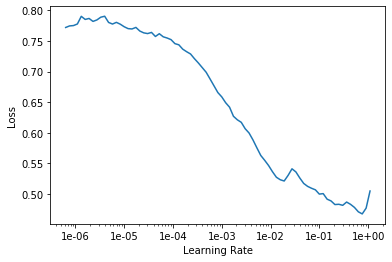

In [35]:
learn_class.lr_find()
learn_class.recorder.plot()

In [36]:
learning_rate = 1e-2
learn_class.fit_one_cycle(5, max_lr = learning_rate, moms = (0.8,0.7))

epoch,train_loss,valid_loss,accuracy,time
0,0.291126,0.192131,0.926600,02:36
1,0.250043,0.179857,0.931360,02:40
2,0.256084,0.181397,0.933200,02:55
3,0.228734,0.172539,0.934040,02:50
4,0.250590,0.175743,0.932920,02:46


In [37]:
learn_class.save("lc_freezed")

**Clearing the GPU Memory**

In [38]:
gpu_mem_get_free_no_cache()

6587

**Finetuning the Learner [Stage 1]**

In [39]:
learn_class.load("lc_freezed");

epoch,train_loss,valid_loss,accuracy,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


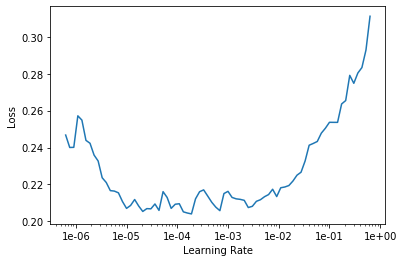

In [47]:
learn_class.freeze_to(-2)
learn_class.lr_find()
learn_class.recorder.plot()

The factor of 2.6**4 in the learning rate below is chosen based on the [ULMFiT paper](https://arxiv.org/abs/1801.06146) written by Jeremy Howard and Sebastian Ruder.

In [48]:
learning_rate = slice(1e-3/(2.6**4), 1e-3)
learn_class.fit_one_cycle(5, max_lr = learning_rate, moms = (0.8,0.7))

epoch,train_loss,valid_loss,accuracy,time
0,0.236594,0.172498,0.934880,03:01
1,0.246520,0.167528,0.938480,03:06
2,0.224673,0.163749,0.938160,03:02
3,0.201720,0.161578,0.939200,02:54
4,0.189763,0.160728,0.939160,03:10


In [49]:
learn_class.save("lc_unfreezed_stage1")

**Clearing the GPU Memory**

In [50]:
gpu_mem_get_free_no_cache()

6391

**Finetuning the Learner [Stage 2]**

In [51]:
learn_class.load("lc_unfreezed_stage1");

epoch,train_loss,valid_loss,accuracy,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


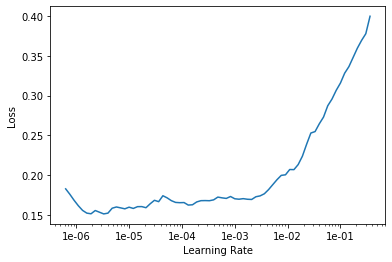

In [53]:
learn_class.freeze_to(-3)
learn_class.lr_find()
learn_class.recorder.plot()

In [54]:
learning_rate = slice(1e-4/(2.6**4), 1e-4)
learn_class.fit_one_cycle(5, max_lr = learning_rate, moms = (0.8,0.7))

epoch,train_loss,valid_loss,accuracy,time
0,0.190900,0.160240,0.939480,03:35
1,0.179736,0.159279,0.940200,03:46
2,0.191410,0.158960,0.940200,04:00
3,0.172282,0.158301,0.940960,03:57
4,0.191780,0.158465,0.940960,04:00


In [55]:
learn_class.save("lc_unfreezed_stage2")

**Clearing the GPU Memory**

In [12]:
gpu_mem_get_free_no_cache()

6762

**Finetuning the Learner [Stage 3]**

In [13]:
learn_class.load("lc_unfreezed_stage2");

epoch,train_loss,valid_loss,accuracy,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


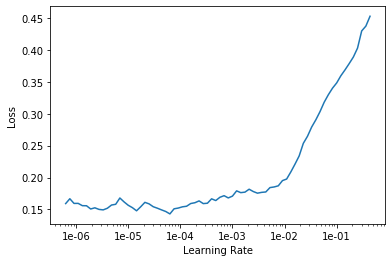

In [14]:
learn_class.unfreeze()
learn_class.lr_find()
learn_class.recorder.plot()

In [15]:
learning_rate = slice(1e-5/(2.6**4), 1e-5)
learn_class.fit_one_cycle(10, max_lr = learning_rate, moms = (0.8,0.7), callbacks = SaveModelCallback(learn_class, name = 'lc_unfreezed_stage3'))

epoch,train_loss,valid_loss,accuracy,time
0,0.171279,0.158593,0.940400,04:08
1,0.175796,0.159821,0.940080,04:23
2,0.175284,0.159137,0.939400,04:29
3,0.168826,0.159436,0.940440,04:37
4,0.180179,0.160670,0.939440,04:18
5,0.175460,0.157886,0.940400,04:51
6,0.190084,0.158994,0.940400,04:46
7,0.175183,0.158308,0.940640,04:32
8,0.185080,0.159865,0.940320,04:19
9,0.169322,0.160425,0.939640,04:26


Better model found at epoch 0 with valid_loss value: 0.15859292447566986.
Better model found at epoch 5 with valid_loss value: 0.1578855812549591.


## Inferencing

In [16]:
valid_loss_metrics = learn_class.validate()
print("Validation Loss: ", valid_loss_metrics[0])
print("Validation Accuracy: ", valid_loss_metrics[1].item() * 100)

Validation Loss:  0.15788558
Validation Accuracy:  94.04000043869019


In [17]:
text = "I loved that movie. It was well-paced, with good action scenes."

In [18]:
result = learn_class.predict(text)
print("Category Name: ", result[0])
print("Category Id: ", result[1].item())
print("Probabilities: ", result[2])

Category Name:  pos
Category Id:  1
Probabilities:  tensor([1.2101e-04, 9.9988e-01])


C:\Users\RAJDEEP\Anaconda\Anaconda3\envs\fastaienv\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


## Exporting the trained Language Classifier

In [19]:
learn_class.export('final_trained_language_classifier.pkl', destroy = True)

this Learner object self-destroyed - it still exists, but no longer usable
